In [737]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [738]:
import seaborn as sns
sns.set_palette('Set2')

import matplotlib.pyplot as plt
%matplotlib inline

In [739]:
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [740]:
import requests
import json
from datetime import datetime
import time

In [741]:
import os
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [742]:
from config import yelp_api_key
from config import darksky_api_key

## Set Up

In [3312]:
# Analysis Dates
start_date = '2017-01-01' # Start Date Inclusive
end_date = '2019-06-10' # End Date Exclusive

In [3313]:
search_business = 'Jupiter Disco'
location = 'Brooklyn, NY'

## Pull Weather Data

### Latitude + Longitude from Yelp API

In [3172]:
host = 'https://api.yelp.com'
path = '/v3/businesses/search'

search_limit = 10

# Yelp Authorization Header with API Key
headers = {
        'Authorization': 'Bearer {}'.format(yelp_api_key) 
    }

# Build Requests Syntax with Yelp Host and Path and URL Paramaters
# Return JSON response
def request(host, path, url_params=None):
    
    url_params = url_params or {}
    url = '{}{}'.format(host, path)

    response = requests.get(url, headers=headers, params=url_params)
    
    return response.json()

# Build URL Params for the Request and provide the host and path
def search(term, location):
    
    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': search_limit
    }
    
    return request(host, path, url_params=url_params)

# Return Coordinates if Exact Match Found
def yelp_lat_long(business, location):
    
    # Call search function here with business name and location
    response = search(business, location)
    
    # Set state to 'No Match' in case no Yelp match found
    state = 'No Match'
    possible_matches = []
    
    # Check search returns for match wtith business
    for i in range(len(response['businesses'])):

        # If match found:
        if response['businesses'][i]['name'] == business:

            # Local variables to help navigate JSON return
            response_ = response['businesses'][0]
            name_ = response_['name']

            print(f'Weather Location: {name_}')
            state = 'Match Found'
            #print(response['businesses'][0])
            return response_['coordinates']['latitude'], response_['coordinates']['longitude']

        else:
            
            # If no exact match, append all search returns to list
            possible_matches.append(response['businesses'][i]['name'])
    
    # If no match, show user potential matches
    if state == 'No Match':
        
        print('Exact match not found, did you mean one of the following? \n')
        
        for possible_match in possible_matches:
            print(possible_match)
            
        return None, None

lat, long = yelp_lat_long(search_business, location)
#print(f'Latitude: {lat}\nLongitude: {long}')

Weather Location: Jupiter Disco


### Darksky API Call

In [2334]:
# Create List of Dates of target Weather Data
def find_dates(start_date, end_date):
    
    list_of_days = []
    daterange = pd.date_range(start_date, end_date)
    for single_date in daterange:
        list_of_days.append(single_date.strftime("%Y-%m-%d"))
    
    return list_of_days

In [2335]:
# Concatenate URL to make API Call
def build_url(api_key, lat, long, day):
    
    _base_url = 'https://api.darksky.net/forecast/'
    _time = 'T20:00:00'
    _url = f'{_base_url}{api_key}/{lat},{long},{day + _time}?America/New_York&exclude=flags'
    return _url

def make_api_call(url):
    
    r = requests.get(url)
    
    return r.json()

In [2336]:
# Try / Except Helper Function for Handling JSON API Output
def find_val(dictionary, *keys):

    level = dictionary
    
    for key in keys:
        
        try:
            level = level[key]
            
        except:
            return np.NAN
        
    return level

# Parse API Call Data using Try / Except Helper Function
def parse_data(data):

    time = datetime.fromtimestamp(data['currently']['time']).strftime('%Y-%m-%d')
    
    try:
        precip_max_time = datetime.fromtimestamp(find_val(data, 'daily', 'data', 0, 'precipIntensityMaxTime')).strftime('%I:%M%p')
    
    except:
        precip_max_time = datetime(1900,1,1,5,1).strftime('%I:%M%p')
    
    entry = {'date': time,
             'temperature': float(find_val(data, 'currently', 'temperature')),
             'apparent_temperature': float(find_val(data, 'currently', 'apparentTemperature')),
             'humidity': float(find_val(data, 'currently', 'humidity')),
             'precip_intensity_max': float(find_val(data,'daily','data', 0, 'precipIntensityMax')),
             'precip_type': find_val(data, 'daily', 'data', 0, 'precipType'),
             'precip_prob': float(find_val(data, 'currently', 'precipProbability')),
             'pressure': float(find_val(data, 'currently', 'pressure')),
             'summary': find_val(data, 'currently', 'icon'),
             'precip_max_time': precip_max_time}
    
    return entry

In [2337]:
# Create List of Weather Data Dictionaries & Input Target Dates
def weather_call(start_date, end_date, _lat, _long):
    
    weather = []
    list_of_days = find_dates(start_date, end_date)
    
    for day in list_of_days:
        
        data = make_api_call(build_url(darksky_api_key, _lat, _long, day))
    
        weather.append(parse_data(data))
    
    return weather

result = weather_call(start_date, end_date, lat, long)

In [2522]:
# Build DataFrame from List of Dictionaries
def build_weather_df(api_call_results):

    df = pd.DataFrame(api_call_results)

    # Add day of week to DataFrame + Set Index as date
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    
    df.set_index('date', inplace=True)
    
    df['apparent_temperature'].fillna(method='ffill',inplace=True)
    df['temperature'].fillna(method='ffill',inplace=True)
    df['humidity'].fillna(method='ffill',inplace=True)
    df['precip_prob'].fillna(method='ffill', inplace=True)
    df['pressure'].fillna(method='ffill', inplace=True)
    df['precip_type'].fillna(value='none', inplace=True)
    
    return df

weather_df = build_weather_df(result);

In [2523]:
weather_df.to_csv(f'weather_{start_date}_to_{end_date}.csv')
weather_csv_file = f'weather_{start_date}_to_{end_date}.csv'

## Import / Clean / Prep File

In [4185]:
# Import Sales Data
bar_sales_file = 'bar_x_sales_export.csv'
rest_1_file = 'rest_1_dinner_sales_w_covers.csv'

In [4186]:
# Set File
current_file = rest_1_file
weather_csv_file = 'weather_2017-01-01_to_2019-06-10.csv'

In [4187]:
# HELPER FUNCTION
def filter_df(df, start_date, end_date):
    
    return df[(df.index > start_date) & (df.index < end_date)]

In [4188]:
# HELPER FUNCTION
def import_parse(file):

    data = pd.read_csv(file, index_col = 'date', parse_dates=True)
    df = pd.DataFrame(data)
    
    # Rename Column to 'sales'
    df = df.rename(columns={df.columns[0]: 'sales',
                           'dinner_covers': 'covers'})
    
    # Drop NaN
    #df = df.query('sales > 0').copy()
    df.fillna(0, inplace=True)
    
    print(f'"{file}" has been imported + parsed. The file has {len(df)} rows.')
    
    return df

In [4189]:
# HELPER FUNCTION
def prepare_data(current_file, weather_file):
    
    df = filter_df(import_parse(current_file), start_date, end_date)
    weather_df_csv = pd.read_csv(weather_csv_file, parse_dates=True, index_col='date')
    weather_df_csv['summary'].fillna(value='none', inplace=True)
    
    df = pd.merge(df, weather_df_csv, how='left', on='date')
    
    return df

### Encode Closed Days

In [4190]:
# Set Closed Dates

## REST 1 CLOSED DATES
additional_closed_dates = ['2018-12-24', '2017-12-24', '2017-02-05', '2017-03-14', '2018-02-04', '2019-02-03']

## BAR CLOSED DATES
#additional_closed_dates = ['2018-12-24', '2017-12-24', '2017-10-22']

closed_dates = [pd.to_datetime(date) for date in additional_closed_dates]
drop_closed = False

# Drop or Encode Closed Days
def encode_closed_days(df):

    if drop_closed:
        
        df = df.loc[df[target] > 0]
        
    else:

        # CLOSED FEATURE
        cal = calendar()

        # Local list of days with zero sales
        potential_closed_dates = df[df[target] == 0].index

        # Enocodes closed days with 1
        df['closed'] = np.where((((df.index.isin(potential_closed_dates)) & \
                                  (df.index.isin(cal.holidays(start_date, end_date)))) | df.index.isin(closed_dates)), 1, 0)

    return df

### Replace Outliers in Training Data

In [4191]:
# Replace Outliers with Medians
## Targets for Outliers
primary_targets = ['sales', 'covers']

# Number to Drop for each Day Of Week
max_vals = 3
min_vals = 3

def drop_outliers(df):
    
    for d in df['day_of_week'].unique():
        
        # Create List of Rows to Drop
        outliers = []
        
        # High Targets - Append to outliers list
        outliers.append(list(df[(df['day_of_week'] == d) & (df['closed'] == 0)][target].nlargest(max_vals).index))
        
        # Low Targets - Append to outliers list
        outliers.append(list(df[(df['day_of_week'] == d) & (df['closed'] == 0)][target].nsmallest(min_vals).index))
    
        # Replace Outliers with Mean Values
        daily_median = df.groupby('day_of_week')[target].median()[d]
        
        for i in outliers:
            
            df.loc[i, target] = daily_median
    
    return df

In [4192]:
def add_sales_per_cover(df):
    
    df['sales_per_cover'] = np.where(df['covers'] > 0, df['sales'] / df['covers'], 0)
    
    return df

## Clean File Here

In [4200]:
data = add_sales_per_cover(drop_outliers(encode_closed_days(prepare_data(current_file, weather_csv_file))))

"rest_1_dinner_sales_w_covers.csv" has been imported + parsed. The file has 889 rows.


In [4201]:
data.to_csv('CSV_for_EDA.csv')

### Download CSV for EDA

## CHOOSE TARGET --> SALES OR COVERS

In [4035]:
target = 'covers'

In [4036]:
def daily_average_matrix_ann(df):
    
    matrix = df.groupby([df.index.dayofweek, df.index.month, df.index.year]).agg({target: 'mean'})
    matrix = matrix.rename_axis(['day', 'month', 'year'])
    return matrix.unstack(level=1)

daily_average_matrix_ann(data)

covers                                                          \
month         1       2       3       4       5       6       7       8    
day year                                                                   
0   2017  180.00  179.00  178.00  219.50  215.20  227.25  235.60  243.75   
    2018  146.40  179.00  176.25  185.20  261.75  247.75  249.60  232.00   
    2019  182.00  175.50  188.25  190.40  209.00  278.00     NaN     NaN   
1   2017  181.40  180.50  138.75  214.50  220.60  225.50  232.25  234.80   
    2018  176.00  169.50  171.50  177.00  221.00  252.50  224.60  203.00   
    2019  140.40  174.75  184.75  194.80  199.50  243.00     NaN     NaN   
2   2017  190.50  190.75  188.60  200.00  251.60  267.00  252.25  209.40   
    2018  178.80  180.75  164.25  186.25  231.00  237.00  245.75  241.60   
    2019  179.60  175.50  178.25  217.25  208.00  231.00     NaN     NaN   
3   2017  188.25  191.25  187.00  232.25  228.50  248.60  227.75  259.40   
    2018  173.75  182.25  180.20  206.50  236.40  230.00  256.00  260.00   
    2019  179.60  182.75  187.00  200.00  210.20  253.00     NaN     NaN   
4   2017  202.00  206.25  204.00  255.25  272.50  267.20  249.50  283.75   
    2018  197.75  193.00  199.80  239.50  282.25  267.40  248.75  259.40   
    2019  195.00  202.50  204.60  212.75  277.80  270.00     NaN     NaN   
5   2017  229.00  225.75  227.50  269.40  290.25  326.25  290.20  273.00   
    2018  213.75  211.00  217.00  273.25  259.25  278.00  279.75  250.00   
    2019  223.75  226.75  227.20  270.00  278.00  319.00     NaN     NaN   
6   2017  208.75  157.50  211.25  240.40  265.50  272.75  288.80  281.25   
    2018  196.50  155.75  194.00  220.00  243.25  252.75  261.20  269.75   
    2019  190.50  159.50  204.60  232.00  234.25  278.50     NaN     NaN   

                                          
month         9       10      11      12  
day year                                  
0   2017  233.00  207.00  176.25  132.00  
    2018  216.75  197.00  179.50  138.60  
    2019     NaN     NaN     NaN     NaN  
1   2017  230.25  213.00  178.75  193.75  
    2018  210.50  191.00  170.25  125.25  
    2019     NaN     NaN     NaN     NaN  
2   2017  229.75  231.25  186.60  184.00  
    2018  204.25  200.40  168.00  175.25  
    2019     NaN     NaN     NaN     NaN  
3   2017  258.75  224.25  160.20  191.75  
    2018  217.75  181.75  153.20  175.50  
    2019     NaN     NaN     NaN     NaN  
4   2017  287.60  278.75  215.75  209.00  
    2018  261.50  227.75  195.60  194.00  
    2019     NaN     NaN     NaN     NaN  
5   2017  298.20  309.75  215.25  209.60  
    2018  268.40  251.25  207.00  204.40  
    2019     NaN     NaN     NaN     NaN  
6   2017  277.00  258.00  202.00  164.00  
    2018  249.00  233.75  195.25  199.80  
    2019     NaN     NaN     NaN     NaN

### Create Day & Month Clusters

In [4037]:
from sklearn.cluster import KMeans

day_k = 7
mo_k = 3

def create_clusters(df, col, k):
    
    # MAKE DATAFRAME USING CENTRAL TENDENCIES AS FEATURES
    describe = df.groupby(col)[target].aggregate(['median', 'std', 'max'])
    df = describe.reset_index()
    
    # SCALE TEMPORARY DF
    scaler = MinMaxScaler()
    f = scaler.fit_transform(df)
    
    # INSTANTIATE MODEL
    km = KMeans(n_clusters=k, random_state=0).fit(f)
    
    # GET KMEANS CLUSTER PREDICTIONS
    labels = km.predict(f)
    
    # MAKE SERIES FROM PREDICTIONS
    temp = pd.DataFrame(labels, columns = ['cluster'], index=df.index)
    
    # CONCAT CLUSTERS TO DATAFRAME
    df = pd.concat([df, temp], axis=1)
    
    # CREATE CLUSTER DICTIONARY
    temp_dict = {}
    for i in list(df[col]):
        
        temp_dict[i] = df.loc[df[col] == i, 'cluster'].iloc[0]
    
    return temp_dict

# Create Global Dictionaries to Categorize Day / Month
day_dict = create_clusters(data, 'day_of_week', day_k)
month_dict = create_clusters(data, 'month', mo_k)

In [4038]:
# Print Clusters
print('Day Clusters: ', day_dict, '\n', 'Total Clusters: ', len(set(day_dict.values())), '\n')
print('Month Clusters: ', month_dict, '\n', 'Total Clusters: ', len(set(month_dict.values())))

Day Clusters:  {0: 3, 1: 6, 2: 1, 3: 5, 4: 0, 5: 4, 6: 2} 
 Total Clusters:  7 

Month Clusters:  {1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 2, 12: 2} 
 Total Clusters:  3


### Add Temperature Onehot Categories

In [4039]:
def encode_temp(df):

    temp_enc = KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans')
    temp_enc.fit(df[['apparent_temperature']])
    
    return temp_enc
    
def one_hot_temp(df, temp_enc):
    
    binned_transform = temp_enc.transform(df[['apparent_temperature']])
    binned_df = pd.DataFrame(binned_transform.toarray(), index=df.index, columns=['temp_very_cold', 'temp_cold', 'temp_warm', 'temp_hot', 'temp_very_hot'])
    df = df.merge(binned_df, how='left', on='date')
    df.drop(['apparent_temperature', 'temperature'], axis=1, inplace=True)

    return df, temp_enc

## Feature Engineering

In [4040]:
# Add Clusters to DataFrame to use as Features
def add_clusters(df):
    
    df['day_cluster'] = df['day_of_week'].apply(lambda x: day_dict[x]).astype('category')
    df['month_cluster'] = df['month'].apply(lambda x: month_dict[x]).astype('category')
    
    return df

### Add Weather Features

In [4041]:
hours_start = '05:30PM'
hours_end = '11:59PM'

hs_dt = datetime.strptime(hours_start, "%I:%M%p")
he_dt = datetime.strptime(hours_end, "%I:%M%p")

def between_time(check_time):
        
    if hs_dt <= datetime.strptime(check_time, "%I:%M%p") <= he_dt:

        return 1

    else:

        return 0

In [4042]:
add_weather = True

#avg_precip_max_intensity = np.mean([pmax for pmax in data.precip_intensity_max if pmax != 0])
temp_delta_window = 1

def add_weather_features(df):
    
    if add_weather:
        
        # POOR WEATHER FEATURES
        df['precip_while_open'] = df['precip_max_time'].apply(lambda x: between_time(x))
        #df['strong_precip'] = np.where((df['precip_intensity_max'].apply(lambda x: x > avg_precip_max_intensity)) & (df['precip_while_open'] == 1), 1, 0)
    
        # DROP FEATURES
        features_to_drop = ['precip_intensity_max', 'precip_max_time']
        df.drop(features_to_drop, axis=1, inplace=True)
        
    return df

### Add Calendar Features

In [4043]:
def add_cal_features(df):
    
    cal = calendar()

    # THREE DAY WEEKEND FEATURE
    sunday_three_days = [date + pd.DateOffset(-1) for date in cal.holidays(start_date, end_date) if date.dayofweek == 0]
    df['sunday_three_day'] = np.where(df.index.isin(sunday_three_days), 1, 0)
    
    return df

### Add Dummies

In [4044]:
def add_dummies(df):
    
    df = pd.get_dummies(data=df, columns=['day_cluster', 'month_cluster'])
    
    return df

### Add Interactions

In [4045]:
apply_interactions = True

def add_interactions(df):
    
    if apply_interactions:
        
        for d in [col for col in df.columns if col.startswith('day_cluster')]:
            
            for m in [col for col in df.columns if col.startswith('month_cluster')]:
                
                col_name = d + '_X_' + m
                
                df[col_name] = df[d] * df[m]
                
            df.drop([d], axis=1, inplace=True)
        
        df.drop([col for col in df.columns if col.startswith('month_cluster')], axis=1, inplace=True)
                
        return df
    
    else:
        
        return df

In [4046]:
apply_weather_interactions = True

def add_weather_interactions(df):
    
    if apply_weather_interactions:
        
        try:
            df['outside_X_precip_open'] = df['outside'] * df['precip_while_open']
            
            for w in [col for col in df.columns if col.startswith('temp_')]:

                col_name = w + '_X_' + 'outside'
                df[col_name] = df[w] * df['outside']

            df.drop(['outside'], axis=1, inplace=True)
            
        except:
            pass
        
        return df
    
    else:
        
        return df

### Feature Selection

In [4145]:
def feature_selection(df):
    
    try:
        target_list = ['sales', 'covers', 'sales_per_cover']

        target_to_drop = [t for t in target_list if t != target]

        df = df.drop(target_to_drop, axis=1)
        
    except:
        pass
        
    # Feature Selection / Drop unnecessary or correlated columns
    cols_to_drop = ['day_of_week', 'month', 'precip_type', 'summary', 'pressure']
    
    df = df.drop(cols_to_drop, axis=1)
    
    return df

### Add Target Trend Feature Engineering

In [4146]:
trend_days_rolling = 28
trend_days_shift = 7
days_fwd = trend_days_rolling + trend_days_shift + 1

def target_trend_engineering(df):
    
    df['target_trend'] = df[target].rolling(trend_days_rolling).mean() - df[target].shift(trend_days_shift).rolling(trend_days_rolling).mean()
    df['same_day_target_avg_prev_4_weeks'] = (df[target].shift(7) + df[target].shift(14) + df[target].shift(21) + df[target].shift(28)) / 4
    
    return df

## Start Here

In [4147]:
# IMPORT & PARSE CLEAN TRAINING SET
data = add_sales_per_cover(drop_outliers(encode_closed_days(prepare_data(current_file, weather_csv_file))))

"rest_1_dinner_sales_w_covers.csv" has been imported + parsed. The file has 889 rows.


In [4148]:
# One Hot Encode Temperature Data
data, temp_enc = one_hot_temp(data, encode_temp(data))

In [4149]:
# Create CSV
data.to_csv('csv_before_features.csv')

In [4150]:
def feature_engineering(df):
    
    df.columns = df.columns.map(str)
    
    # Add day & Month Clusters // Dicts with data held in Global Variable
    df = add_clusters(df)
    
    # Add Engineered Features for Weather & Calendar
    df = add_weather_features(df)
    df = add_cal_features(df)
    
    # Create Dummies
    df = add_dummies(df)
    
    # Add Interactions
    df = add_interactions(df)
    df = add_weather_interactions(df)
    
    # Drop Selected Columns
    df = feature_selection(df)
    
    return df

dfx = feature_engineering(data)

In [4151]:
dfx = target_trend_engineering(dfx)

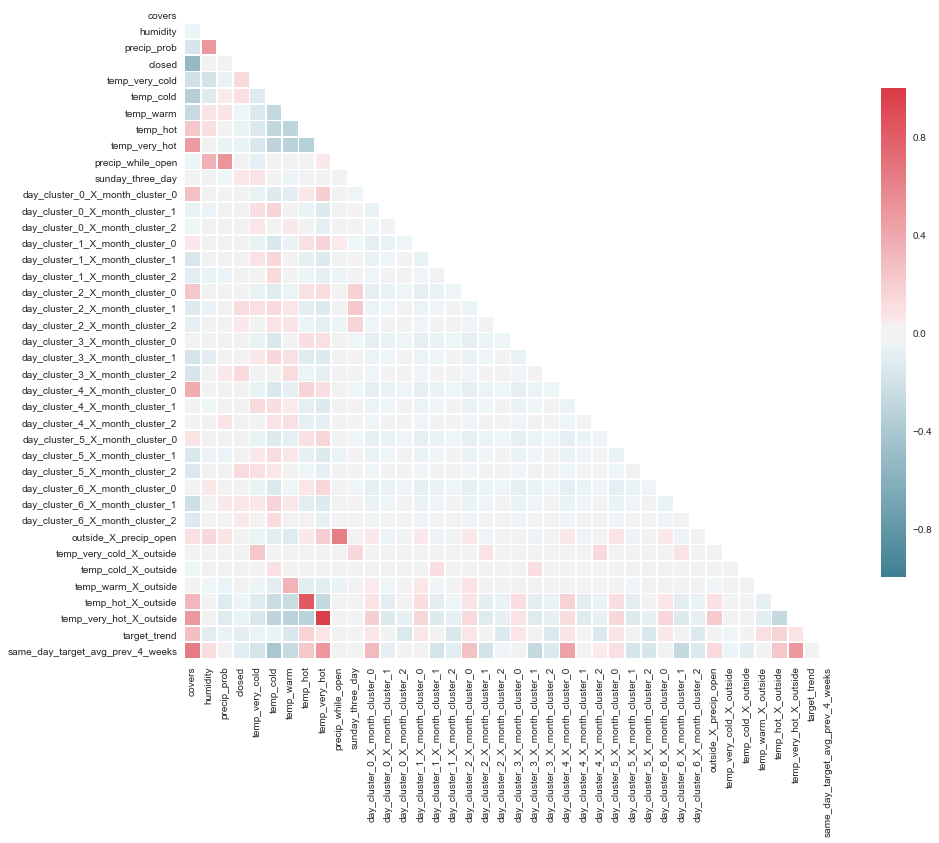

In [4152]:
def corr_chart(df):
    
    corr = dfx.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    sns.set_style('whitegrid')
    f, ax = plt.subplots(figsize=(16, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.75, annot=False, cbar_kws={"shrink": .75});
    
corr_chart(dfx)

## Update Sales

In [4153]:
# # File from Start based on Target Variable
# current_sales_df = import_parse(rest_1_file)

In [4154]:
# date = '2019-06-13'
# sales = 15209.75
# covers = 207
# outside = 1
# closed = 0

# def add_sales_row(date, sales):
    
#     df = pd.DataFrame({'sales': sales,
#                        'covers': covers,
#                       'outside': outside,
#                       'closed': closed},
#                        index=[date])
    
#     return df

# temp = add_sales_row(date, sales)

In [4155]:
# def build_sales_df(df, temp):
    
#     df = df.append(temp)
    
#     return df
    
# current_sales_df = build_sales_df(current_sales_df, temp)

In [4156]:
# Download Current DataFrame to CSV
current_sales_df.to_csv(f'rest_1_clean_updated_{start_date}_to_{end_date}.csv')

In [4157]:
df_import = pd.read_csv('rest_1_clean_updated_2017-01-01_to_2019-06-10.csv', parse_dates=True, index_col='Unnamed: 0')

def import_current(df):
    
    df.index = pd.to_datetime(df.index)
    
    df = add_sales_per_cover(df)
    
    target_list = ['sales', 'covers', 'sales_per_cover']

    target_to_drop = [t for t in target_list if t != target]

    df = df.drop(target_to_drop, axis=1)
    
    return df

current_df = import_current(df_import)

### Add Recent Sales Data

In [4158]:
# Import Most Recent DataFrame
df_before_features = pd.read_csv('csv_before_features.csv', index_col='date', parse_dates=True)

# Create New Weather DataFrame with Updated Data
new_date_start = '2019-06-10'
new_date_end = '2019-06-13'

def update_current_df(sales_df, df_before_features, new_date_start, new_end_date):
    
    sales_df = sales_df[new_date_start:]
    
    sales_df = sales_df.rename_axis(index = 'date')
    sales_df.index = pd.to_datetime(sales_df.index)

    ## Find Lat Long for Business
    lat, long = yelp_lat_long(search_business, location)

    ## Pull Weather Data / Forecast
    weather_df = build_weather_df(weather_call(new_date_start, new_date_end, lat, long))
    
    ## Parse, Clean, Engineer
    df = pd.merge(sales_df, weather_df, how='left', on='date')
    df, _ = one_hot_temp(df, temp_enc)
    df = pd.concat([df_before_features, df])
    df = target_trend_engineering(feature_engineering(df))
    
    return df
    
current_df = update_current_df(current_df, df_before_features, new_date_start, new_date_end)

Weather Location: Jupiter Disco


## Test / Train / Split

In [4159]:
def cv_split(df):
    
    features = dfx.drop([target], axis=1)[days_fwd:]
    y = dfx[target][days_fwd:]
    
    return features, y

cv_features, cv_y = cv_split(current_df)

In [4160]:
def train_test_split(df):
    
    # Separate Target & Features
    y = df[target]
    features = df.drop([target], axis=1)
    
    # Test / Train / Split
    train_date_start = '2017-01-01'
    train_date_end = '2018-12-31'
    
    X_train = features[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    X_test = features[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    y_train = y[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    y_test = y[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    # Scale
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)
    
    print('Train set: ', len(X_train))
    print('Test set: ', len(X_test))
    
    return X_train, X_test, y_train, y_test, scaler
    
X_train, X_test, y_train, y_test, scaler = train_test_split(current_df)

Train set:  694
Test set:  164


In [4161]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class FeatureEngineer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col):
        self.col = col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.col]
    
    
cluster = Pipeline([
                    ('selector', FeatureEngineer(col='day_of_week')),
                    
])

### Linear Regression

In [4162]:
def linear_regression_model(X_train, y_train):
    
    lr = LinearRegression(fit_intercept=True)
    lr_rgr = lr.fit(X_train, y_train)
    
    return lr_rgr

In [4163]:
lr_rgr = linear_regression_model(X_train, y_train)

In [4164]:
def rgr_score(rgr, X_train, y_train, X_test, y_test, cv_features, cv_y):
    
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    y_pred = rgr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
    
    print('Root Mean Squared Error: ', rmse, '\n')
    
    print('Cross Val Avg R-Squared: ',  \
          np.mean(cross_val_score(rgr, cv_features, cv_y, cv=10, scoring='r2')), '\n')
    
    print('Intercept:  ', rgr.intercept_, '\n')
    print('Coefficients:  \n')
    
    for index, col_name in enumerate(X_test.columns):
        print(col_name, ' --> ', rgr.coef_[index])

In [4165]:
rgr_score(lr_rgr, X_train, y_train, X_test, y_test, cv_features, cv_y)

Train R-Squared:   0.8254364241819013
Test R-Squared:   0.8212755124712959 

Root Mean Squared Error:  18.519700556700847 

Cross Val Avg R-Squared:  0.6892373516199288 

Intercept:   35346519433952.34 

Coefficients:  

closed  -->  -183.6275539814067
humidity  -->  -10.918821505722526
precip_prob  -->  -11.234733966652879
temp_cold  -->  -26401822668363.855
temp_hot  -->  -26401822668362.04
temp_very_cold  -->  -26401822668363.86
temp_very_hot  -->  -26401822668360.9
temp_warm  -->  -26401822668361.97
precip_while_open  -->  8.599401551853408
sunday_three_day  -->  -1.672545349132303
day_cluster_0_X_month_cluster_0  -->  -8944696765417.342
day_cluster_0_X_month_cluster_1  -->  -8944696765424.486
day_cluster_0_X_month_cluster_2  -->  -8944696765421.238
day_cluster_1_X_month_cluster_0  -->  -8944696765443.975
day_cluster_1_X_month_cluster_1  -->  -8944696765441.512
day_cluster_1_X_month_cluster_2  -->  -8944696765440.264
day_cluster_2_X_month_cluster_0  -->  -8944696765416.62
day_clust

### Prediction Function

In [4166]:
outside = 1

def predict_df(clf, scaler, X_train, current_df, date_1, date_2):
    
    # Find Lat Long for Business
    lat, long = yelp_lat_long(search_business, location)
    
    # Pull Weather Data / Forecast
    weather_df = build_weather_df(weather_call(date_1, date_2, lat, long))
    
    day_of_week, apparent_temperature = weather_df['day_of_week'], weather_df['apparent_temperature']
    weather_df['outside'] = outside
    
    # One Hot Encode Temperature Using Fitted Encoder
    df, _ = one_hot_temp(weather_df, temp_enc)
    
    # Add Feature Engineering
    df = feature_engineering(df)
    
    # Add Sales Data for Sales Trend Engineering
    current_df = current_df[target]
    df = pd.merge(df, current_df, on='date', how='left')
    df[target] = df[target].fillna(method='ffill')
    
    df = target_trend_engineering(df)
    df = df.drop([target], axis=1)
    
    # Ensure Column Parity
    missing_cols = set(X_train.columns) - set(df.columns)
    
    for c in missing_cols:
        df[c] = 0
        
    df = df[X_train.columns][-2:]
    
    # Scale Transform
    df_scaled = scaler.transform(df)
    df = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    
    # Predict and Build Prediction DataFrame for Review
    pred_array = pd.DataFrame(clf.predict(df), index=df.index, columns=[target])
    pred_df = df[df.columns[(df != 0).any()]]
    pred_df = pd.concat([pred_df, day_of_week, apparent_temperature], axis=1)
    
    final_predict = pd.concat([pred_array, pred_df], axis=1)
    
    return final_predict

In [4167]:
tonight = predict_df(lr_rgr, scaler, X_train, current_df, pd.datetime.now().date() + pd.DateOffset(-days_fwd), pd.datetime.now().date())
tonight[-2:]

Weather Location: Jupiter Disco


,covers,humidity,temp_hot,temp_very_hot,day_cluster_0_X_month_cluster_0,day_cluster_5_X_month_cluster_0,temp_hot_X_outside,temp_very_hot_X_outside,target_trend,same_day_target_avg_prev_4_weeks,day_of_week,apparent_temperature
date,,,,,,,,,,,,
2019-06-13,242.734375,0.684932,1.0,0.0,0.0,1.0,1.0,0.0,0.548289,0.560000,3,64.14
2019-06-14,287.195312,0.191781,0.0,1.0,1.0,0.0,0.0,1.0,0.542966,0.794872,4,72.82


## Lasso

In [4168]:
def lasso_model(X_train, y_train):

    lassoReg = Lasso(fit_intercept=True, alpha=.01)
    lasso_rgr = lassoReg.fit(X_train,y_train)

    return lasso_rgr

lasso_rgr = lasso_model(X_train, y_train)

In [4169]:
rgr_score(lasso_rgr, X_train, y_train, X_test, y_test, cv_features, cv_y)

Train R-Squared:   0.8253646518185183
Test R-Squared:   0.8215060273598118 

Root Mean Squared Error:  18.5077535532611 

Cross Val Avg R-Squared:  0.6900122186530585 

Intercept:   155.00477503802878 

Coefficients:  

closed  -->  -182.88651344548705
humidity  -->  -10.807577766517507
precip_prob  -->  -10.616025665170651
temp_cold  -->  -1.6148241970713502
temp_hot  -->  0.0
temp_very_cold  -->  -1.7543881534053773
temp_very_hot  -->  0.7223384978260109
temp_warm  -->  0.09086279257684003
precip_while_open  -->  7.77662699701118
sunday_three_day  -->  -0.9427644401266922
day_cluster_0_X_month_cluster_0  -->  18.431608470427687
day_cluster_0_X_month_cluster_1  -->  10.661844426335493
day_cluster_0_X_month_cluster_2  -->  13.849167135192381
day_cluster_1_X_month_cluster_0  -->  -7.9791970565174015
day_cluster_1_X_month_cluster_1  -->  -5.521365516849754
day_cluster_1_X_month_cluster_2  -->  -4.500852164384405
day_cluster_2_X_month_cluster_0  -->  19.076656801854597
day_cluster_2_X_mon

In [4122]:
tonight = predict_df(lasso_rgr, scaler, X_train, current_df, pd.datetime.now().date() + pd.DateOffset(-days_fwd), pd.datetime.now().date())
tonight[-2:]

Weather Location: Jupiter Disco


,covers,humidity,pressure,temp_hot,temp_very_hot,day_cluster_0_X_month_cluster_0,day_cluster_5_X_month_cluster_0,temp_hot_X_outside,temp_very_hot_X_outside,target_trend,same_day_target_avg_prev_4_weeks,day_of_week,apparent_temperature
date,,,,,,,,,,,,,
2019-06-13,242.239278,0.684932,0.358302,1.0,0.0,0.0,1.0,1.0,0.0,0.548289,0.560000,3,64.14
2019-06-14,286.819373,0.191781,0.509513,0.0,1.0,1.0,0.0,0.0,1.0,0.542966,0.794872,4,72.82


<Figure size 864x576 with 0 Axes>

ResidualsPlot(alpha=0.75,
       ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1c26f15748>,
       hist=False, line_color=None, model=None, test_color=None,
       train_color=None)

0.8212279728453031

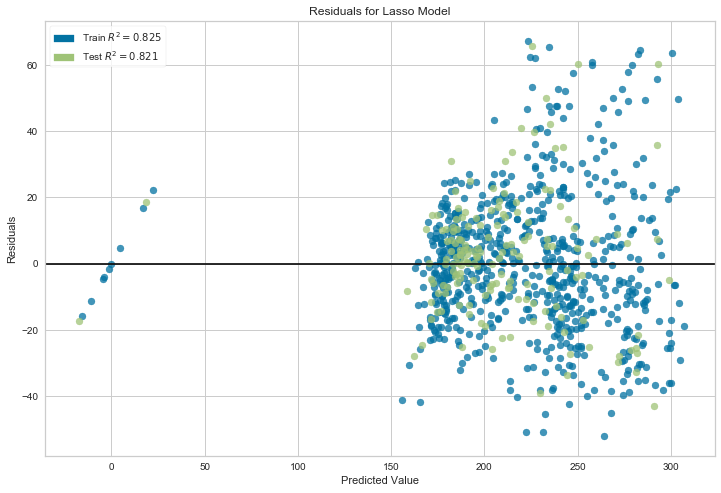

In [4123]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features.importances import FeatureImportances

plt.figure(figsize=(12,8))

visualizer = ResidualsPlot(lasso_rgr, hist=False)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

FeatureImportances(absolute=False,
          ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1c26ebceb8>,
          labels=['Closed', 'Humidity', 'Precip_Prob', 'Pressure', 'Temp_Cold', 'Temp_Hot', 'Temp_Very_Cold', 'Temp_Very_Hot', 'Temp_Warm', 'Precip_While_Open', 'Sunday_Three_Day', 'Day_Cluster_0_X_Month_Cluster_0', 'Day_Cluster_0_X_Month_Cluster_1', 'Day_Cluster_0_X_Month_Cluster_2', 'Day_Cluster_1_X_Month_C...Temp_Very_Hot_X_Outside', 'Temp_Warm_X_Outside', 'Target_Trend', 'Same_Day_Target_Avg_Prev_4_Weeks'],
          model=None, relative=False, stack=False, xlabel=None)

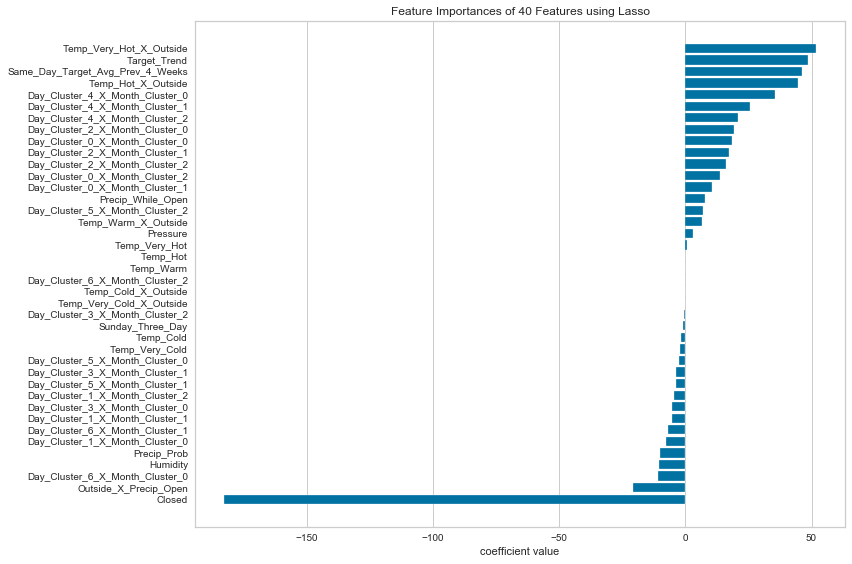

In [4124]:
features = list(X_train.columns)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

labels = list(map(lambda x: x.title(), features))
visualizer = FeatureImportances(lasso_rgr, ax=ax, labels=labels, relative=False)

visualizer.fit(X_train, y_train)
visualizer.poof()

### Random Forest Regression

In [4125]:
def rf_regression_model(X_train, y_train):
    
    rfr = RandomForestRegressor(max_depth= 7, 
                                max_features= 0.75, 
                                min_impurity_decrease= 0.001, 
                                n_estimators= 300)
    rfr_rgr = rfr.fit(X_train, y_train)
    
    return rfr_rgr

In [4126]:
rfr_rgr = rf_regression_model(X_train, y_train)

In [4127]:
def rfr_score(rgr, X_test, y_test, cv_features, cv_y):
    
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    y_pred = rgr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
    
    print('Root Mean Squared Error: ', rmse, '\n')
    
    print('Cross Val Avg R-Squared: ',  \
          np.mean(cross_val_score(rgr, cv_features, cv_y, cv=10, scoring='r2')), '\n')
        
rfr_score(rfr_rgr, X_test, y_test, cv_features, cv_y) 

Train R-Squared:   0.8889722877911967
Test R-Squared:   0.7810798637867794 

Root Mean Squared Error:  20.49673966051266 

Cross Val Avg R-Squared:  0.6472544673681957 



### Random Forest Regression Prediction

In [4128]:
tonight = predict_df(rfr_rgr, scaler, X_train, current_df, pd.datetime.now().date() + pd.DateOffset(-days_fwd), pd.datetime.now().date())
tonight[-2:]

Weather Location: Jupiter Disco


,covers,humidity,pressure,temp_hot,temp_very_hot,day_cluster_0_X_month_cluster_0,day_cluster_5_X_month_cluster_0,temp_hot_X_outside,temp_very_hot_X_outside,target_trend,same_day_target_avg_prev_4_weeks,day_of_week,apparent_temperature
date,,,,,,,,,,,,,
2019-06-13,235.860390,0.684932,0.358302,1.0,0.0,0.0,1.0,1.0,0.0,0.548289,0.560000,3,64.14
2019-06-14,284.166564,0.191781,0.509513,0.0,1.0,1.0,0.0,0.0,1.0,0.542966,0.794872,4,72.82


### Decision Tree Regressor

In [4129]:
def dt_regression_model(X_train, y_train):
    
    dt = DecisionTreeRegressor(max_depth= 7, 
                                max_features= 0.85,
                               random_state=0)
    
    dt_rgr = dt.fit(X_train, y_train)
    
    return dt_rgr

In [4130]:
dt_rgr = dt_regression_model(X_train, y_train)

In [4131]:
rfr_score(dt_rgr, X_test, y_test, cv_features, cv_y) 

Train R-Squared:   0.8586408592740685
Test R-Squared:   0.7076957326368809 

Root Mean Squared Error:  23.684242981790188 

Cross Val Avg R-Squared:  0.44419902879092665 



### Grid Search Helper Function

In [1612]:
def run_grid_search(rgr, params, X_train, y_train):
    
    cv = 5
    n_jobs = -1
    scoring = 'r2'
    
    grid = GridSearchCV(rgr, params, cv=cv, n_jobs=n_jobs, scoring=scoring, verbose=10)
    grid = grid.fit(X_train, y_train)
    
    best_grid_rgr = grid.best_estimator_
    
    print('Grid Search: ', rgr.__class__.__name__, '\n')
    print('Grid Search Best Score: ', grid.best_score_)
    print('Grid Search Best Params: ', grid.best_params_)
    print('Grid Search Best Estimator: ', grid.best_estimator_)

    return best_grid_rgr


In [1617]:
params = {
          'n_estimators': [250, 300, 400,500],
          'max_depth': [5, 7, 9, 11, 13, 60],
          'min_impurity_decrease': [0.005, 0.001, 0.0001],
          'max_features': ['auto', 0.65, 0.75, 0.85]
        }

best_grid_rgr = run_grid_search(rfr_rgr, params, X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

Grid Search:  RandomForestRegressor 

Grid Search Best Score:  0.6701191976394486
Grid Search Best Params:  {'max_depth': 7, 'max_features': 0.75, 'min_impurity_decrease': 0.001, 'n_estimators': 300}
Grid Search Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.75, max_leaf_nodes=None,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [189]:
rfr_rgr.get_params().keys()

dict_keys(['bootstrap', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [591]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [4137]:
dfx.head()

,covers,humidity,precip_prob,pressure,closed,temp_very_cold,temp_cold,temp_warm,temp_hot,temp_very_hot,...,day_cluster_6_X_month_cluster_1,day_cluster_6_X_month_cluster_2,outside_X_precip_open,temp_very_cold_X_outside,temp_cold_X_outside,temp_warm_X_outside,temp_hot_X_outside,temp_very_hot_X_outside,target_trend,same_day_target_avg_prev_4_weeks
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,173.0,0.93,0.74,1027.76,0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2017-01-03,184.0,0.95,0.70,999.38,0,0.0,0.0,1.0,0.0,0.0,...,1,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2017-01-04,176.0,0.37,0.00,1003.24,0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2017-01-05,190.0,0.49,0.00,1014.93,0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2017-01-06,194.0,0.49,0.00,1023.22,0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [4143]:
f = ''

for c in dfx.columns:
    
    f += c + '+'
    
x = f[6:-1]

In [4144]:
f= target + '~' + x

model = ols(formula=f, data=dfx).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 covers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     106.5
Date:                Fri, 14 Jun 2019   Prob (F-statistic):          4.01e-287
Time:                        19:01:39   Log-Likelihood:                -3783.8
No. Observations:                 855   AIC:                             7646.
Df Residuals:                     816   BIC:                             7831.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                          111.6969     80.870      1.381      0.168     -47.041     270.435
humidity                           -13.4537      4.870     -2.763      0.006     -23.013      -3.894
precip_prob                        -11.3191      4.371     -2.589      0.010     -19.899      -2.739
pressure                             0.0341      0.099      0.344      0.731      -0.160       0.229
closed                            -184.2808      6.347    -29.036      0.000    -196.738    -171.823
temp_very_cold                      18.3907     16.780      1.096      0.273     -14.547      51.328
temp_cold                           20.4240     16.458      1.241      0.215     -11.880      52.728
temp_warm                           22.8703     16.231      1.409      0.159      -8.989      54.730
temp_hot                            23.6167     16.141      1.463      0.144      -8.066      55.299
temp_very_hot                       26.3950     17.134      1.540      0.124      -7.237      60.027
precip_while_open                    7.6228      3.908      1.951      0.051      -0.048      15.293
sunday_three_day                     3.7447      5.849      0.640      0.522      -7.737      15.226
day_cluster_0_X_month_cluster_0     19.2888      4.933      3.910      0.000       9.606      28.972
day_cluster_0_X_month_cluster_1     10.3134      5.186      1.989      0.047       0.134      20.493
day_cluster_0_X_month_cluster_2     13.9524      6.169      2.262      0.024       1.843      26.062
day_cluster_1_X_month_cluster_0    -10.2338      4.784     -2.139      0.033     -19.624      -0.844
day_cluster_1_X_month_cluster_1     -7.4511      5.143     -1.449      0.148     -17.546       2.644
day_cluster_1_X_month_cluster_2     -5.8884      6.406     -0.919      0.358     -18.462       6.685
day_cluster_2_X_month_cluster_0     18.3884      4.993      3.683      0.000       8.587      28.190
day_cluster_2_X_month_cluster_1     13.4058      5.447      2.461      0.014       2.713      24.098
day_cluster_2_X_month_cluster_2     15.1096      6.374      2.371      0.018       2.599      27.620
day_cluster_3_X_month_cluster_0     -7.2894      4.796     -1.520      0.129     -16.703       2.125
day_cluster_3_X_month_cluster_1     -5.8957      5.673     -1.039      0.299     -17.031       5.239
day_cluster_3_X_month_cluster_2     -2.0444      6.419     -0.319      0.750     -14.643      10.554
day_cluster_4_X_month_cluster_0     36.6594      5.192      7.060      0.000      26.468      46.851
day_cluster_4_X_month_cluster_1     28.4109      5.480      5.185      0.000      17.655      39.167
day_cluster_4_X_month_cluster_2     21.8603      6.287      3.477      0.001       9.519      34.201
day_cluster_5_X_month_cluster_0     -5.0597      4.76